## Voting(Bagging(ET)+Bagging(RF))

In [17]:
# import module
import numpy as np
import pandas as pd
import random
import os

import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess, Fourier

rcParams['figure.figsize'] = 16, 8

In [18]:
# setting seed
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 2021
seed_everything(SEED)

In [19]:
# oil data
calendar = pd.DataFrame(index=pd.date_range('2013-01-01', '2017-08-31'))

data_oil = pd.read_csv('/content/drive/MyDrive/kaggle/store-sales-time-series-forecasting/oil.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')
data_oil['ma_oil'] = data_oil['dcoilwtico'].rolling(7).mean()

calendar = calendar.merge(data_oil, how='left', left_index=True, right_index=True)
calendar['ma_oil'].fillna(method='ffill', inplace=True)
calendar['dofw'] = calendar.index.dayofweek

In [20]:
# holiday data
df_hev = pd.read_csv('/content/drive/MyDrive/kaggle/store-sales-time-series-forecasting/holidays_events.csv', parse_dates=['date'], infer_datetime_format=True)

df_hev['date'] = df_hev['date'].replace({'2013-04-29' : 
                                         pd.to_datetime('2013-03-29')}) 
df_hev = df_hev.set_index('date').sort_index()

df_hev = df_hev[df_hev.locale == 'National'] 

df_hev = df_hev.groupby(df_hev.index).first() 

In [21]:
# work day
calendar['wd'] = True
calendar.loc[calendar.dofw > 4, 'wd'] = False

calendar = calendar.merge(df_hev, how='left', left_index=True, right_index=True)

calendar.loc[calendar.type == 'Bridge'  , 'wd'] = False
calendar.loc[calendar.type == 'Work Day', 'wd'] = True
calendar.loc[calendar.type == 'Transfer', 'wd'] = False
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = False
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True ), 'wd'] = True

In [22]:
# train data
df_train = pd.read_csv('/content/drive/MyDrive/kaggle/store-sales-time-series-forecasting/train.csv',
                       usecols=['store_nbr', 'family', 'date', 'sales'],
                       dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32'},
                       parse_dates=['date'], infer_datetime_format=True)

df_train.date = df_train.date.dt.to_period('D')
df_train = df_train.set_index(['store_nbr', 'family', 'date']).sort_index()

In [23]:
# test data
df_test = pd.read_csv('/content/drive/MyDrive/kaggle/store-sales-time-series-forecasting/test.csv',
                      usecols=['store_nbr', 'family', 'date'],
                      dtype={'store_nbr': 'category', 'family': 'category'},
                      parse_dates=['date'], infer_datetime_format=True)

df_test.date = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [24]:
# start date & end data
sdate = '2017-04-01'
edate = '2017-08-15'

In [25]:
# setting model
y = df_train.unstack(['store_nbr', 'family']).loc[sdate:edate]

fourier = CalendarFourier(freq='W', order=4)

dp = DeterministicProcess(index=y.index,
                          constant=False,
                          order=1,
                          seasonal=False,
                          additional_terms=[fourier],
                          drop=True)
X = dp.in_sample()

# Extentions

X['oil']  = calendar.loc[sdate:edate]['ma_oil'].values
X['dofw'] = calendar.loc[sdate:edate]['dofw'].values
X['wd']   = calendar.loc[sdate:edate]['wd'].values
X['type'] = calendar.loc[sdate:edate]['type'].values

X = pd.get_dummies(X, columns=['dofw'], drop_first=True)
X = pd.get_dummies(X, columns=['type'], drop_first=False)

model = Ridge(fit_intercept=True, solver='auto', alpha=0.4, normalize=True, random_state=SEED)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,


In [26]:
# target
y_pred   = y_pred.stack(['store_nbr', 'family']).reset_index()
y_target = y.stack(['store_nbr', 'family']).reset_index().copy()

y_target['sales_pred'] = y_pred['sales'].clip(0.) # Sales should be >= 0

y_target.groupby('family').apply(lambda r: mean_squared_log_error(r['sales'], r['sales_pred']))

family
AUTOMOTIVE                    0.257738
BABY CARE                     0.066539
BEAUTY                        0.265203
BEVERAGES                     0.197832
BOOKS                         0.026635
BREAD/BAKERY                  0.124268
CELEBRATION                   0.293661
CLEANING                      0.203749
DAIRY                         0.135016
DELI                          0.107789
EGGS                          0.145464
FROZEN FOODS                  0.144047
GROCERY I                     0.209230
GROCERY II                    0.344623
HARDWARE                      0.273053
HOME AND KITCHEN I            0.258068
HOME AND KITCHEN II           0.218346
HOME APPLIANCES               0.153741
HOME CARE                     0.121014
LADIESWEAR                    0.257345
LAWN AND GARDEN               0.212797
LINGERIE                      0.398337
LIQUOR,WINE,BEER              0.608135
MAGAZINES                     0.252873
MEATS                         0.121380
PERSONAL CARE     

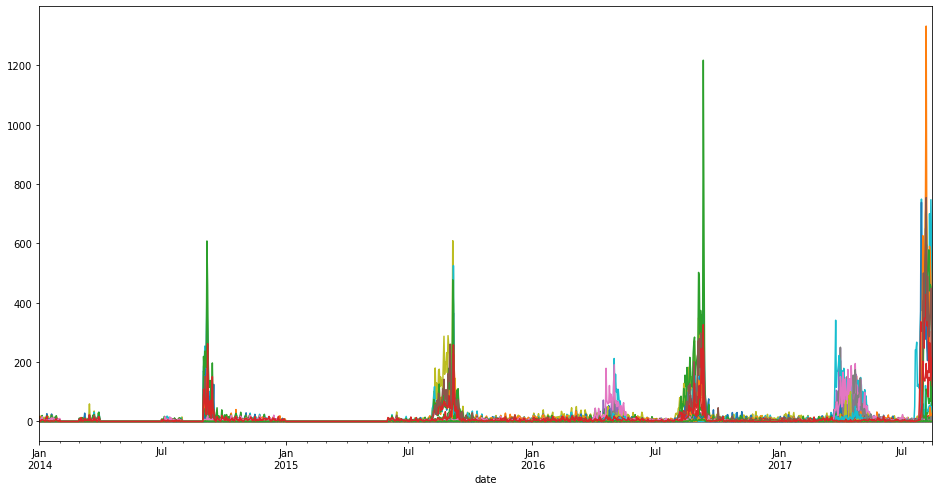

In [27]:
# plot
df_train.unstack(['store_nbr', 'family']).loc['2014':].loc(axis=1)['sales', :, 'SCHOOL AND OFFICE SUPPLIES'].plot(legend=None)

linear regression의 성능이 별로 좋지 않으므로, linear regression 대신 random forest를 사용한다.

In [28]:
# random forest module
from joblib import Parallel, delayed
import warnings

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor

In [29]:
# model
class CustomRegressor():
    
    def __init__(self, n_jobs=-1, verbose=0):
        
        self.n_jobs = n_jobs
        self.verbose = verbose
        
        self.estimators_ = None
        
    def _estimator_(self, X, y):
    
        warnings.simplefilter(action='ignore', category=FutureWarning)
        
        if y.name[2] == 'SCHOOL AND OFFICE SUPPLIES':
            r1 = ExtraTreesRegressor(n_estimators=500, n_jobs=-1, random_state=SEED)
            r2 = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=SEED)
            b1 = BaggingRegressor(base_estimator=r1,
                                  n_estimators=10,
                                  n_jobs=-1,
                                  random_state=SEED)
            b2 = BaggingRegressor(base_estimator=r2,
                                  n_estimators=10,
                                  n_jobs=-1,
                                  random_state=SEED)
            model = VotingRegressor([('et', b1), ('rf', b2)])
        else:
            model = Ridge(fit_intercept=True, solver='auto', alpha=0.5, normalize=True, random_state=SEED)

        model.fit(X, y)

        return model

    def fit(self, X, y):

        self.estimators_ = Parallel(n_jobs=self.n_jobs, 
                              verbose=self.verbose,
                              )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in range(y.shape[1]))
        
        return
    
    def predict(self, X):
        
        y_pred = Parallel(n_jobs=self.n_jobs, 
                          verbose=self.verbose)(delayed(e.predict)(X) for e in self.estimators_)
        
        return np.stack(y_pred, axis=1)

In [ ]:
# training model
model = CustomRegressor(n_jobs=-1, verbose=0)

model.fit(X, y)

y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [33]:
# predict
y_pred   = y_pred.stack(['store_nbr', 'family']).reset_index()
y_target = y.stack(['store_nbr', 'family']).reset_index().copy()

y_target['sales_pred'] = y_pred['sales'].clip(0.) # Sales should be >= 0

y_target.groupby('family').apply(lambda r: mean_squared_log_error(r['sales'], r['sales_pred']))

family
AUTOMOTIVE                    0.259202
BABY CARE                     0.066660
BEAUTY                        0.267450
BEVERAGES                     0.199187
BOOKS                         0.026701
BREAD/BAKERY                  0.125449
CELEBRATION                   0.295910
CLEANING                      0.204513
DAIRY                         0.136196
DELI                          0.108830
EGGS                          0.147672
FROZEN FOODS                  0.145027
GROCERY I                     0.210306
GROCERY II                    0.347753
HARDWARE                      0.273930
HOME AND KITCHEN I            0.259483
HOME AND KITCHEN II           0.219104
HOME APPLIANCES               0.154737
HOME CARE                     0.122103
LADIESWEAR                    0.259483
LAWN AND GARDEN               0.216374
LINGERIE                      0.400216
LIQUOR,WINE,BEER              0.612719
MAGAZINES                     0.254086
MEATS                         0.123141
PERSONAL CARE     

overfitting이 발생했음을 알 수 있다.

In [34]:
# change date
stest = '2017-08-16'
etest = '2017-08-31'

X_test = dp.out_of_sample(steps=16)

# Extentions

X_test['oil']  = calendar.loc[stest:etest]['ma_oil'].values
X_test['dofw'] = calendar.loc[stest:etest]['dofw'].values
X_test['wd']   = calendar.loc[stest:etest]['wd'].values

X_test = pd.get_dummies(X_test, columns=['dofw'], drop_first=True)

# No national level events in this period
X_test[['type_Additional', 'type_Event', 'type_Holiday', 'type_Transfer']] = 0

sales_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
sales_pred = sales_pred.stack(['store_nbr', 'family'])

sales_pred[sales_pred < 0] = 0. # Sales should be >= 0

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


시작 날짜와 종료 날짜를 바꿔 overfitting을 해결했다.

In [36]:
# submission
df_sub = pd.read_csv('/content/drive/MyDrive/kaggle/store-sales-time-series-forecasting/sample_submission.csv', index_col='id')
df_sub.sales = sales_pred.values
df_sub.to_csv('submission1.csv', index=True)

### Prediction Result

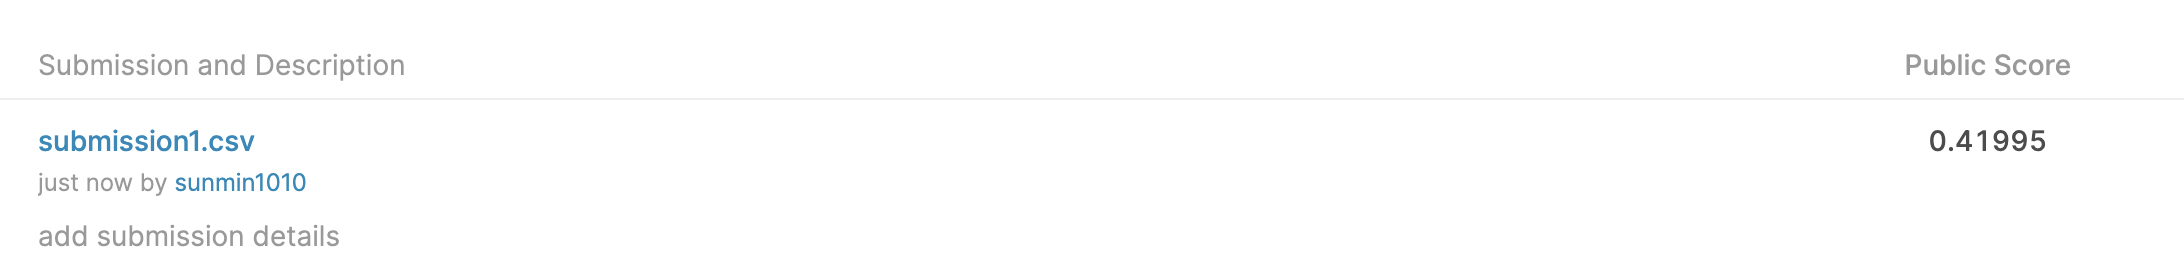